# CSC2042 RNJNEE001
## Assignment 4: Artificial Neural Networks and Hyperparameter Tuning
### Due Date: 11:59 PM, Sunday, 16th June 2024



# **Question 1: Data Loading and Preprocessing (2 marks)**
###### First we create a custom dataset class to load the Fashion-MNIST data from CSV (this is for pytorch compatibility). Then we normalise the data using z-score normalisation and create data loaders for training and validation sets (the validation set is actually the test set given in the resources). Finally, we print the shapes of the datasets and a sample batch to verify correctness.

In [1]:
from torch.utils.data import Dataset

class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        data = pd.read_csv(csv_file)
        self.labels = torch.tensor(data.iloc[:, 0].values, dtype=torch.long)
        self.images = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float32) / 255.0
        self.images = self.images.reshape(-1, 1, 28, 28)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


In [2]:
from torch.utils.data import DataLoader
from torchvision import transforms

#best practice to normalise images uses z score normalisation
z_score_transform = transforms.Normalize((0.5,), (0.5,))
train_dataset = FashionMNISTDataset(csv_file='fashion-mnist_train.csv', transform=z_score_transform)
#were using the provided test set as validation set because ther was a typo or smthn
validation_dataset = FashionMNISTDataset(csv_file='fashion-mnist_test.csv', transform=z_score_transform)

#convert them to dataloaders for pytorch training                           
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

#chceking shapes
train_images, train_labels = next(iter(train_loader))
val_images, val_labels = next(iter(val_loader))

print(f"Train set size: {len(train_dataset)} samples")
print(f"Validation set size: {len(validation_dataset)} samples")
print(f"Train batch shape: {train_images.shape}, Labels: {train_labels.shape}")
print(f"Validation batch shape: {val_images.shape}, Labels: {val_labels.shape}")

NameError: name 'pd' is not defined

# **Question 2: Building and Training a Baseline Model (3 marks)**
We define a simple feedforward neural network with two hidden layers, ReLU activations, and dropout for regularization. The model is trained using the Adam optimizer and cross-entropy loss. After training, we evaluate the model on the validation set and print the accuracy. The model architecture is basically taken from the class notes, with some modifications that allow sigmoid activation and dropout rate to be specified later on (this is done using the activate function and dropout layers respectively).


In [14]:
import torch.nn as nn

class SimpleNet(nn.Module):
    def __init__(self,hidden_layer_1 = 128,activation_method='relu',dropout_rate=0):
        super(SimpleNet, self).__init__()
        self.activation_method = activation_method
        self.dropout_rate = dropout_rate
        #it has 28x28 inptuts (28x28 grayscale image)
        self.first_layer = nn.Linear(28*28, hidden_layer_1)
        self.second_layer = nn.Linear(hidden_layer_1, 64)
        self.output_layer = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=dropout_rate)
        
    #generalising which activation function to use in the forward pass
    def activate(self,x):
        if self.activation_method == 'relu':
            return torch.relu(x)
        elif self.activation_method == 'sigmoid':
            return torch.sigmoid(x)
        else:
            raise ValueError("Unsupported activation method")
        
    def forward(self, x):
        #dropout after each hidden later hepls prevent overfitting
        x = x.view(x.size(0),-1)  # flatten the input
        x = self.activate(self.first_layer(x))
        x = self.dropout(x)
        x = self.activate(self.second_layer(x))
        x = self.dropout(x)
        x = self.output_layer(x)
        return x
    


# **Question 2: Training loop functions (2 marks)**

We create 2 functions to train the model. The first function trains the model and returns the validation accuracy after training for a specified number of epochs. The second function trains the model while also recording the training and validation losses for each epoch, which can be useful for plotting loss curves later.

The first function `train_model` trains the model and evaluates its accuracy on the validation set after training. It takes the model, data loaders, loss criterion, optimizer, device (CPU/GPU), and number of epochs as inputs.

The second function `train_model_with_losses` is similar but also tracks the training and validation losses for each epoch, returning these losses for further analysis or plotting. The second model was made into a seperate function purely for readability purposes when plotting loss curves later on.

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=3):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    # Validation accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (correct / total)*100


In [16]:
def train_model_with_losses(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

    return train_losses, val_losses


# **Question 2: Training the Baseline Model (3 marks)**
we train the baseline model using the defined training function and print the validation accuracy after training for 10 epochs. The standard basline model has the following parameters:
- Hidden Layer 1 Size: 128
- Activation Function: ReLU
- Dropout Rate: 0.0
- Optimizer: Adam
- Learning Rate: 0.001
- Epochs: 10

we also set the processing device to gpu if available for faster training.

In [17]:
import torch
#training baseline model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
val_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, device,epochs=10)
print(f'Validation Accuracy: {val_accuracy:.2f}%')

Validation Accuracy: 89.17%


# **Question 3: Hyperparameter  (8 marks)**
We implement a grid search to explore different hyperparameter combinations for the neural network. The hyperparameters we tune include learning rate, optimizer type, hidden layer size, activation function, and dropout rate. For each combination, we train the model and evaluate its validation accuracy, storing the results for later analysis.

In [18]:
import torch
import itertools

def grid_search(train_loader, val_loader, criterion, device,num_epochs):
    # Define hyperparameter grids
    learning_rates = [0.1, 0.01, 0.001]
    optimizers = ['Adam', 'SGD', 'RMSprop']
    hidden_sizes = [64, 128, 256]
    activations = ['relu', 'sigmoid']
    dropout_rates = [0.1, 0.25, 0.5]

    results = []

    # Generate all combinations using itertools.product
    for lr, opt_name, hidden, act, drop in itertools.product(
        learning_rates, optimizers, hidden_sizes, activations, dropout_rates
    ):
        # Create model with chosen parameters
        model = SimpleNet(hidden_layer_1=hidden, activation_method=act, dropout_rate=drop).to(device)
        
        # Choose optimizer
        if opt_name == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        elif opt_name == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        elif opt_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
        else:
            raise ValueError("Unsupported optimizer")

        # Train model and get validation accuracy
        val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs = num_epochs)
        
        # Store results
        results.append({
            'lr': lr,
            'optimizer': opt_name,
            'hidden_size': hidden,
            'activation': act,
            'dropout': drop,
            'val_accuracy': val_acc
        })
        
        print(f"LR={lr}, OPT={opt_name}, H1={hidden}, ACT={act}, DROP={drop} → ACC={val_acc:.4f}")

    return results


# **Question 4: Running the Grid Search and Analyzing Results (2 marks)**

This is just analysis. We use a pandas table to show the top 10 best configs based on validation accuracy. We create loss curves for the baseline and best model, and display a confusion matrix for the best model on the validation set.

In [20]:
#okay lets run the grid search
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

results = grid_search(train_loader, val_loader, criterion, device,num_epochs=5)         



LR=0.1, OPT=Adam, H1=64, ACT=relu, DROP=0.1 → ACC=10.0000
LR=0.1, OPT=Adam, H1=64, ACT=relu, DROP=0.25 → ACC=10.0000
LR=0.1, OPT=Adam, H1=64, ACT=relu, DROP=0.5 → ACC=10.0000
LR=0.1, OPT=Adam, H1=64, ACT=sigmoid, DROP=0.1 → ACC=52.7200
LR=0.1, OPT=Adam, H1=64, ACT=sigmoid, DROP=0.25 → ACC=53.5800
LR=0.1, OPT=Adam, H1=64, ACT=sigmoid, DROP=0.5 → ACC=40.7800
LR=0.1, OPT=Adam, H1=128, ACT=relu, DROP=0.1 → ACC=10.0000
LR=0.1, OPT=Adam, H1=128, ACT=relu, DROP=0.25 → ACC=10.0000
LR=0.1, OPT=Adam, H1=128, ACT=relu, DROP=0.5 → ACC=10.0000
LR=0.1, OPT=Adam, H1=128, ACT=sigmoid, DROP=0.1 → ACC=38.4900
LR=0.1, OPT=Adam, H1=128, ACT=sigmoid, DROP=0.25 → ACC=25.5400
LR=0.1, OPT=Adam, H1=128, ACT=sigmoid, DROP=0.5 → ACC=19.6000
LR=0.1, OPT=Adam, H1=256, ACT=relu, DROP=0.1 → ACC=10.0000
LR=0.1, OPT=Adam, H1=256, ACT=relu, DROP=0.25 → ACC=10.0000
LR=0.1, OPT=Adam, H1=256, ACT=relu, DROP=0.5 → ACC=10.0000
LR=0.1, OPT=Adam, H1=256, ACT=sigmoid, DROP=0.1 → ACC=10.0000
LR=0.1, OPT=Adam, H1=256, ACT=sigmoi

In [30]:
#disaply gird search results as a dataframe
import pandas as pd

print("\nAll Grid Search Results:")
results_df = pd.DataFrame(results)
print(results_df)

print("\nTop 10 Best Models:")
results_df = results_df.sort_values(by='val_accuracy', ascending=False)
print(results_df.head(10))  # Show top 10 best-performing models



All Grid Search Results:
        lr optimizer  hidden_size activation  dropout  val_accuracy
0    0.100      Adam           64       relu     0.10         10.00
1    0.100      Adam           64       relu     0.25         10.00
2    0.100      Adam           64       relu     0.50         10.00
3    0.100      Adam           64    sigmoid     0.10         52.72
4    0.100      Adam           64    sigmoid     0.25         53.58
..     ...       ...          ...        ...      ...           ...
157  0.001   RMSprop          256       relu     0.25         87.09
158  0.001   RMSprop          256       relu     0.50         86.14
159  0.001   RMSprop          256    sigmoid     0.10         87.01
160  0.001   RMSprop          256    sigmoid     0.25         87.25
161  0.001   RMSprop          256    sigmoid     0.50         85.95

[162 rows x 6 columns]

Top 10 Best Models:
        lr optimizer  hidden_size activation  dropout  val_accuracy
120  0.001      Adam          256       relu 

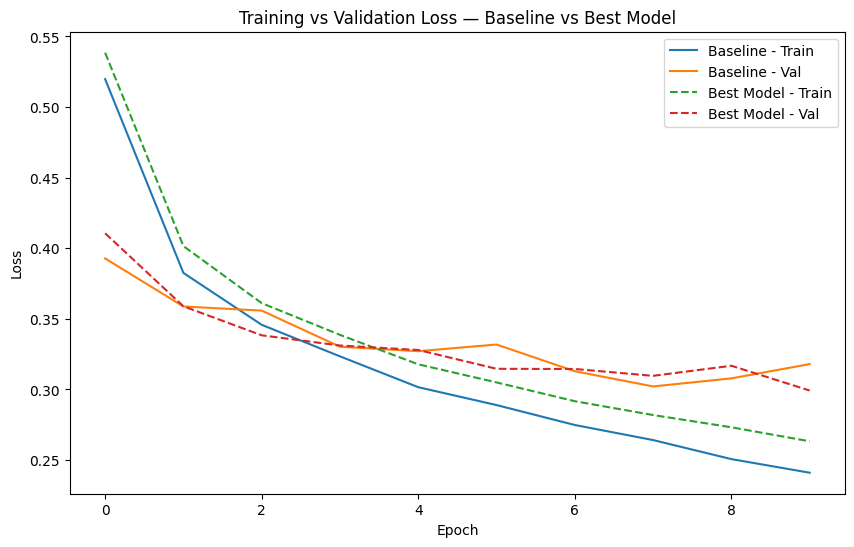

In [26]:
#baseline vs best model loss curves on 10 epochs
# Baseline model
import matplotlib.pyplot as plt
baseline_model = SimpleNet().to(device)
baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)
train_loss_base, val_loss_base = train_model_with_losses(
    baseline_model, train_loader, val_loader, criterion, baseline_optimizer, device, epochs=10
)

# Best model from grid search was 0.001      Adam          256       relu     0.10         88.18
best_model = SimpleNet(hidden_layer_1=256, activation_method='relu', dropout_rate=0.1).to(device)
best_optimizer = torch.optim.Adam(best_model.parameters(), lr=0.001)
train_loss_best, val_loss_best = train_model_with_losses(
    best_model, train_loader, val_loader, criterion, best_optimizer, device, epochs=10
)

# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_loss_base, label='Baseline - Train')
plt.plot(val_loss_base, label='Baseline - Val')
plt.plot(train_loss_best, label='Best Model - Train', linestyle='--')
plt.plot(val_loss_best, label='Best Model - Val', linestyle='--')
plt.title("Training vs Validation Loss — Baseline vs Best Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


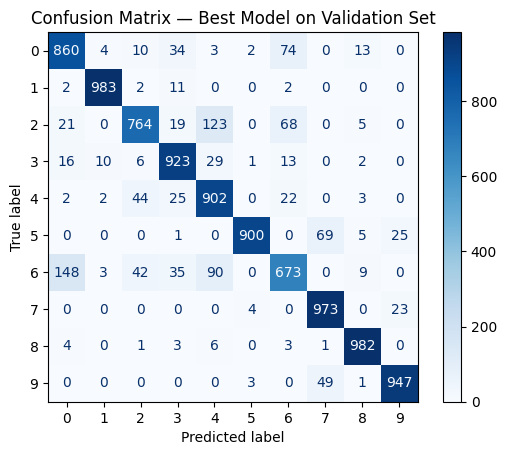

In [27]:
#Confusion matrix for best model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Evaluate best model on validation data
best_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix — Best Model on Validation Set")
plt.show()


In [ ]:
# End of Assignment 4